In [1]:
import pandas as pd
import holoviews as hv
from holoviews.operation.datashader import datashade
from datashader.colors import viridis, inferno
from datashader.reductions import mean
hv.notebook_extension('seaborn')

In [2]:
def make_datashade_plot(pts, cut, extent, cmap, good=True, agg=None):
    ''' Make single plot with datashader
    Parameters:
        pts : holoviews Points object
            Points object made from dataframe with x, y, and z columns
            The z column is the one on which you want to make good/bad cuts
        cut : float
            Value to cut z column at
        extent : 4-tuple
            x- and y-limits to apply to plot, of format (xmin, ymin, xmax, ymax)
        cmap : datashader colormap object
            Datashader colormap; haven't tested it with mpl or palettable
        good : Boolean
            Whether this is the "good" or "bad" value plot. If good, takes values
            below the cut value; if bad, takes values above cut
        agg : None or datashader aggregator object
            Reduction to apply to shaded points; defaults to 'count'.
            See datashader documentation
            
    Returns:
        shaded : holoviews datashade object
    '''
    if good:
        pts_cut = pts[:,:,:cut]
    else:
        pts_cut = pts[:,:,cut:]
    if agg is not None:
        shaded = datashade(pts_cut, height=300, width=400,
                           aggregator=agg,
                           cmap=cmap, dynamic=False,
                           x_range=(extent[0], extent[2]),
                           y_range=(extent[1], extent[3]))
    else:
        shaded = datashade(pts_cut, height=300, width=400,
                           cmap=cmap, dynamic=False,
                           x_range=(extent[0], extent[2]),
                           y_range=(extent[1], extent[3]))
    return shaded

def make_goodbad_plots(df, cutlist, xparam='logT_Exp', yparam='logL_Exp', zparam='chi2min',
                       cmap=viridis, agg=None):
    ''' Make single plot with datashader
    Parameters:
        df : pandas Dataframe object
            Dataframe of BEAST output
        cutlist : list
            List of values to make cuts at
        xparam : str
            Column of dataframe to use as x-value in top two plots.
            Defaults to 'logT_Exp'
        yparam : str
            Column of dataframe to use as y-value in top two plots
            Defaults to 'logL_Exp'
        zparam : str
            Column of dataframe to use as y-value in top two plots
            Defaults to 'chi2min'
        cmap : datashader colormap object
            Datashader colormap; haven't tested it with mpl or palettable
        agg : None or datashader aggregator object
            Reduction to apply to shaded points; defaults to 'count'.
            See datashader documentation
            
    Returns:
        hm : holoviews HoloMap object
    '''

    param_extent = (df[xparam].min(), df[yparam].min(), df[xparam].max(), df[yparam].max())
    spatial_extent = (df.RA.min(), df.DEC.min(), df.RA.max(), df.DEC.max())
    param_pts = hv.Points(df[[xparam, yparam, zparam]], extents=param_extent, label='param')
    spatial_collist = ['RA', 'DEC', zparam]
    if hasattr(agg, 'column'):
        if agg.column not in spatial_collist:
            spatial_collist += [agg.column]
    spatial_pts = hv.Points(df[spatial_collist],  extents=spatial_extent, label='spatial')
    
    goodbad_dict = {}
    for i in cutlist:
        param_good = make_datashade_plot(param_pts, i, param_extent, cmap)
        param_bad = make_datashade_plot(param_pts, i, param_extent, cmap, good=False)
        spatial_good = make_datashade_plot(spatial_pts, i, spatial_extent, cmap, agg=agg)
        spatial_bad = make_datashade_plot(spatial_pts, i, spatial_extent, cmap, good=False, agg=agg)
        
        goodbad_plot = param_good + param_bad + spatial_good + spatial_bad
        goodbad_dict.update({i:goodbad_plot})
        
    hm = hv.HoloMap(goodbad_dict, kdims=[zparam])
    return hm

In [3]:
# read in hdf file of Beast results
# this can also be done with dask if the file is larger than memory
df = pd.read_hdf('PHAT_BEAST-selected/b15_stats_toothpick_v1.1.hdf5', key='data')
df.shape

(1762060, 182)

In [4]:
# list of values to make chi2min cut at
cutlist = [3,20,50,100]
# make first holomap object using only default parameters
hm1 = make_goodbad_plots(df, cutlist)

/Users/luxemburg/anaconda3/envs/ds34/lib/python3.4/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.82914799892, right=4.82914799892
  'left=%s, right=%s') % (left, right))
/Users/luxemburg/anaconda3/envs/ds34/lib/python3.4/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.82914799892, right=4.82914799892
  'left=%s, right=%s') % (left, right))


:Layout
   .RGB.Param.I    :HoloMap   [chi2min]
      :RGB   [logT_Exp,logL_Exp]   (R,G,B,A)
   .RGB.Param.II   :HoloMap   [chi2min]
      :RGB   [logT_Exp,logL_Exp]   (R,G,B,A)
   .RGB.Spatial.I  :HoloMap   [chi2min]
      :RGB   [RA,DEC]   (R,G,B,A)
   .RGB.Spatial.II :HoloMap   [chi2min]
      :RGB   [RA,DEC]   (R,G,B,A)
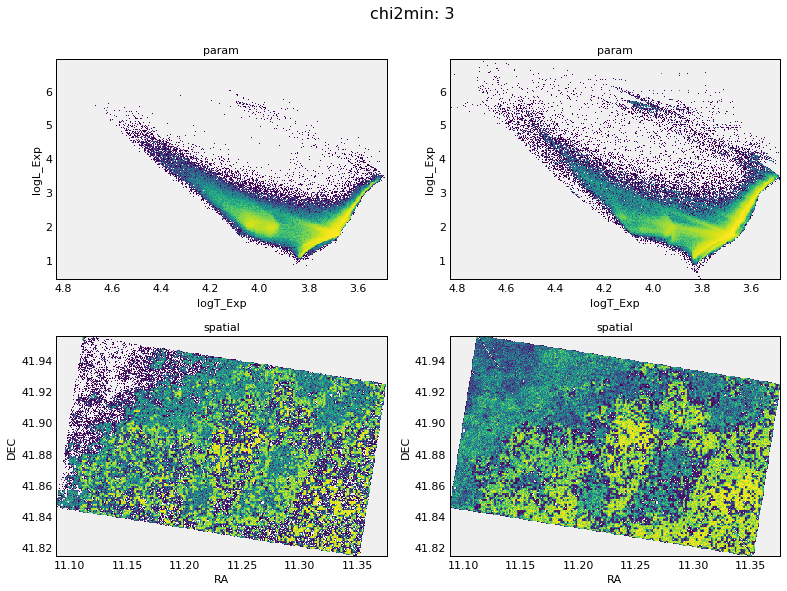
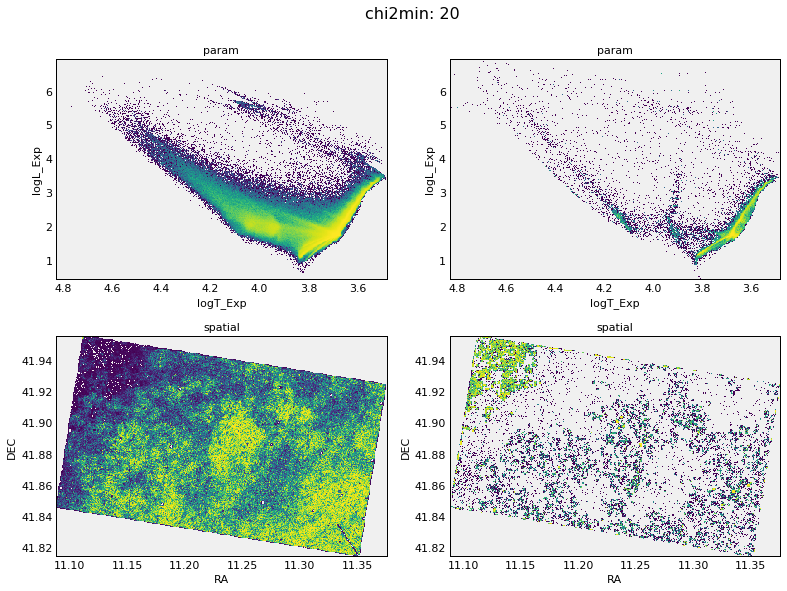
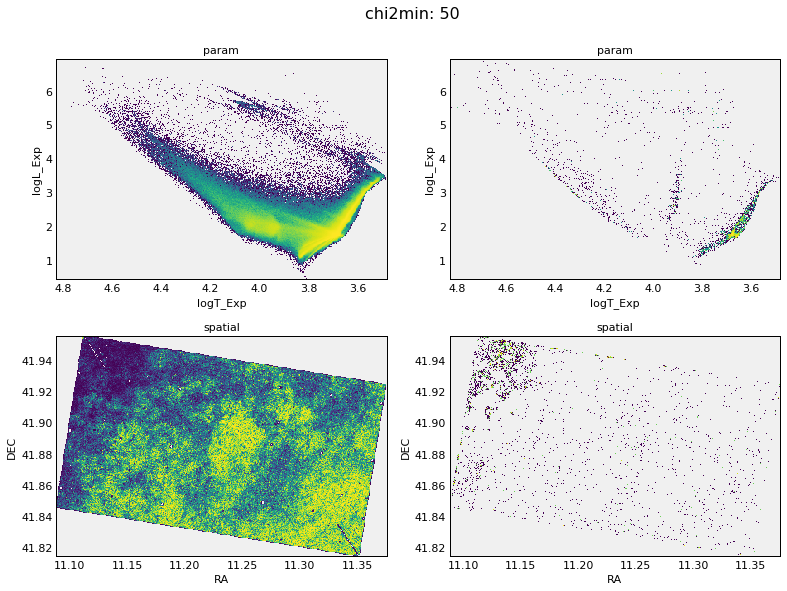
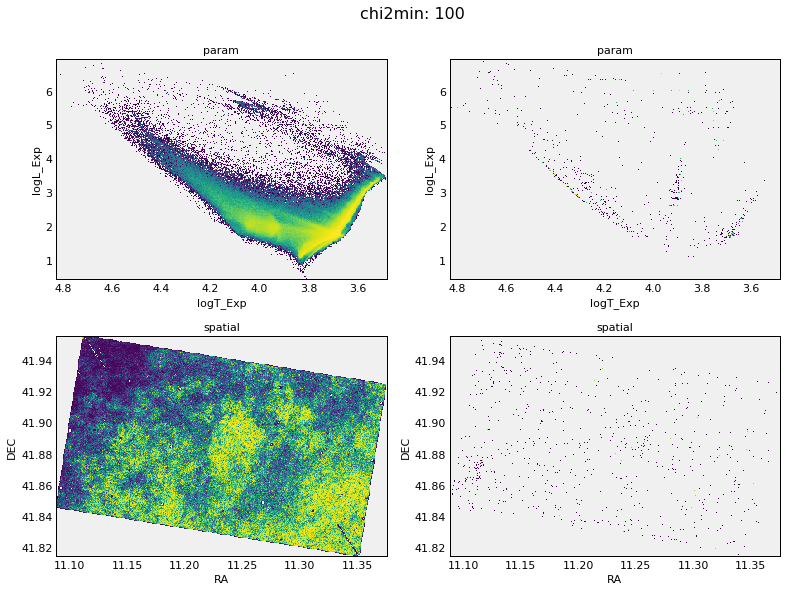

In [5]:
%opts Layout [tight=True fig_inches=(10,8) fig_size=120 sublabel_format=''] RGB [aspect=1.5]\
RGB.param [invert_xaxis=True]
hm1.collate().cols(2)

In [6]:
hm2 = make_goodbad_plots(df, cutlist, xparam='Rv_Exp', yparam='Av_Exp',
                        cmap=inferno, agg=mean(column='Av_Exp'))

:Layout
   .RGB.Param.I    :HoloMap   [chi2min]
      :RGB   [Rv_Exp,Av_Exp]   (R,G,B,A)
   .RGB.Param.II   :HoloMap   [chi2min]
      :RGB   [Rv_Exp,Av_Exp]   (R,G,B,A)
   .RGB.Spatial.I  :HoloMap   [chi2min]
      :RGB   [RA,DEC]   (R,G,B,A)
   .RGB.Spatial.II :HoloMap   [chi2min]
      :RGB   [RA,DEC]   (R,G,B,A)
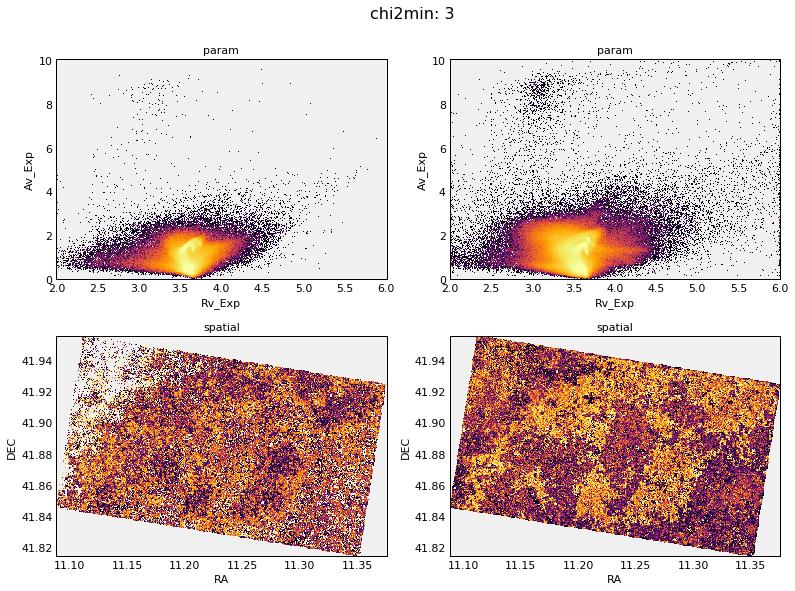
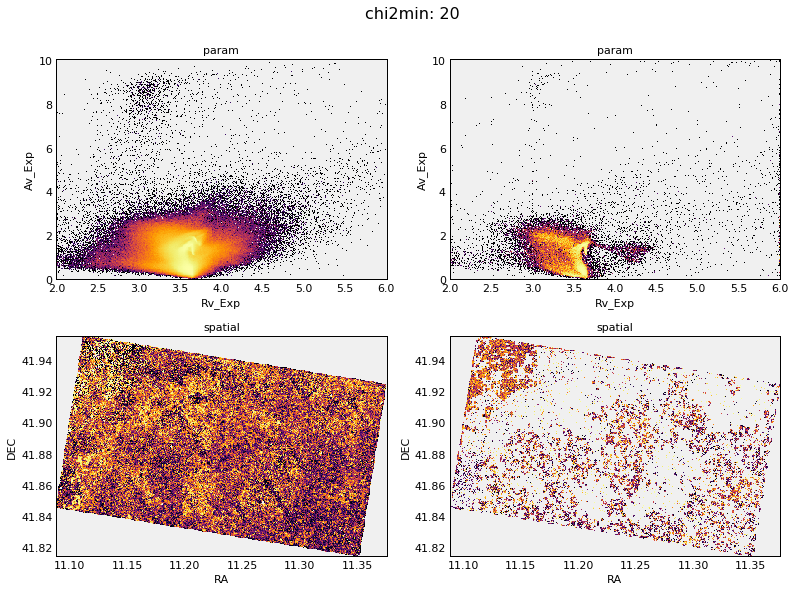
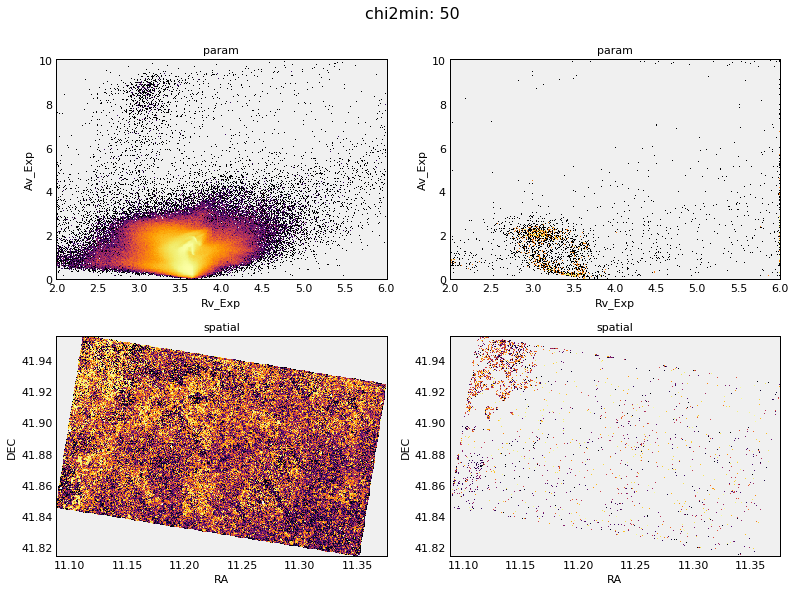
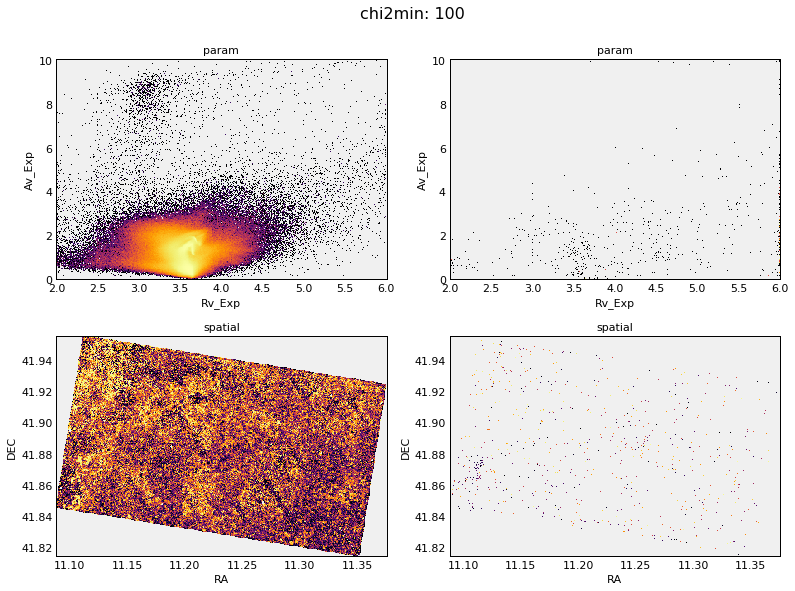

In [7]:
# make plot showing Av vs Rv instead of HR diagram on top two plots
%opts RGB.param [invert_xaxis=False]
hm2.collate().cols(2)

In [8]:
# agn_index = 537425

In [9]:
# use Av as column to make cuts on instead of chi2min, while showing HR diagram again
av_cutlist = [0.5,1,2,3,4,6]
hm3 = make_goodbad_plots(df, av_cutlist, xparam='logT_Exp', yparam='logL_Exp', zparam='Av_Exp',
                        cmap=inferno, agg=mean(column='Av_Exp'))

/Users/luxemburg/anaconda3/envs/ds34/lib/python3.4/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.82914799892, right=4.82914799892
  'left=%s, right=%s') % (left, right))
/Users/luxemburg/anaconda3/envs/ds34/lib/python3.4/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=4.82914799892, right=4.82914799892
  'left=%s, right=%s') % (left, right))


:Layout
   .RGB.Param.I    :HoloMap   [Av_Exp]
      :RGB   [logT_Exp,logL_Exp]   (R,G,B,A)
   .RGB.Param.II   :HoloMap   [Av_Exp]
      :RGB   [logT_Exp,logL_Exp]   (R,G,B,A)
   .RGB.Spatial.I  :HoloMap   [Av_Exp]
      :RGB   [RA,DEC]   (R,G,B,A)
   .RGB.Spatial.II :HoloMap   [Av_Exp]
      :RGB   [RA,DEC]   (R,G,B,A)
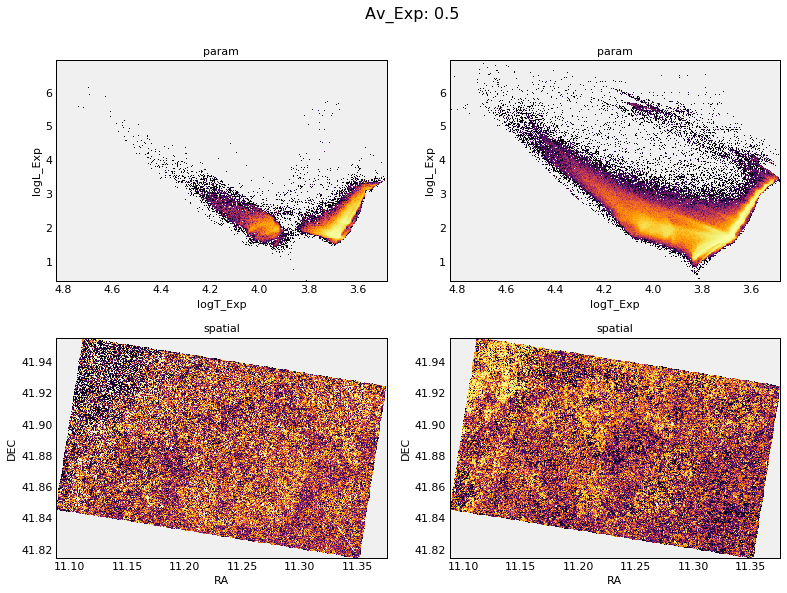
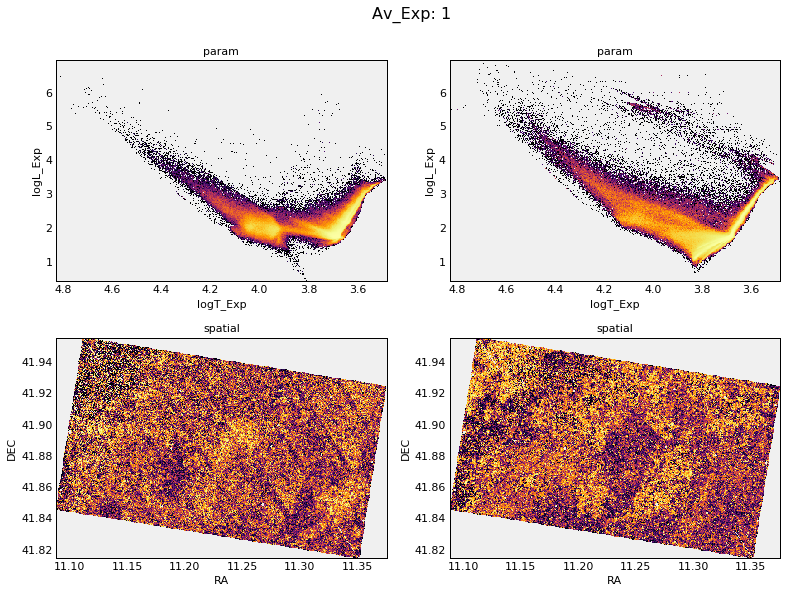
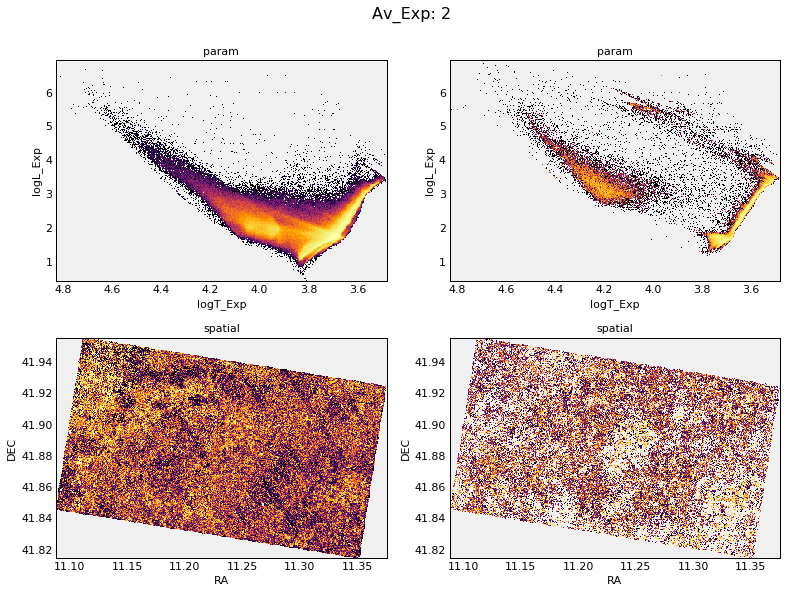
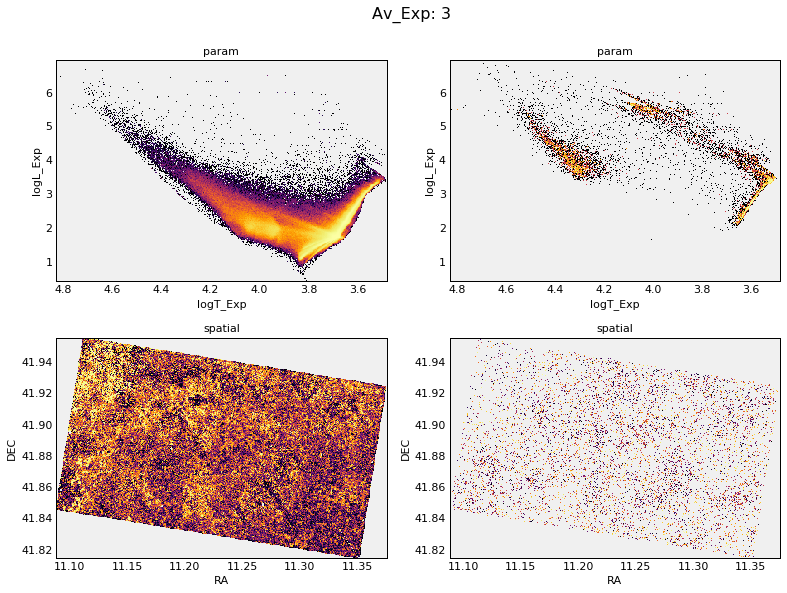
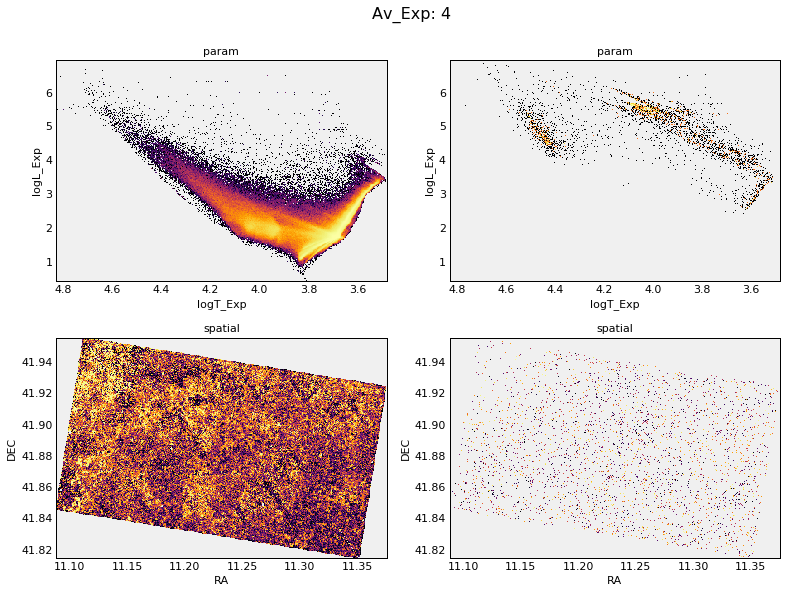
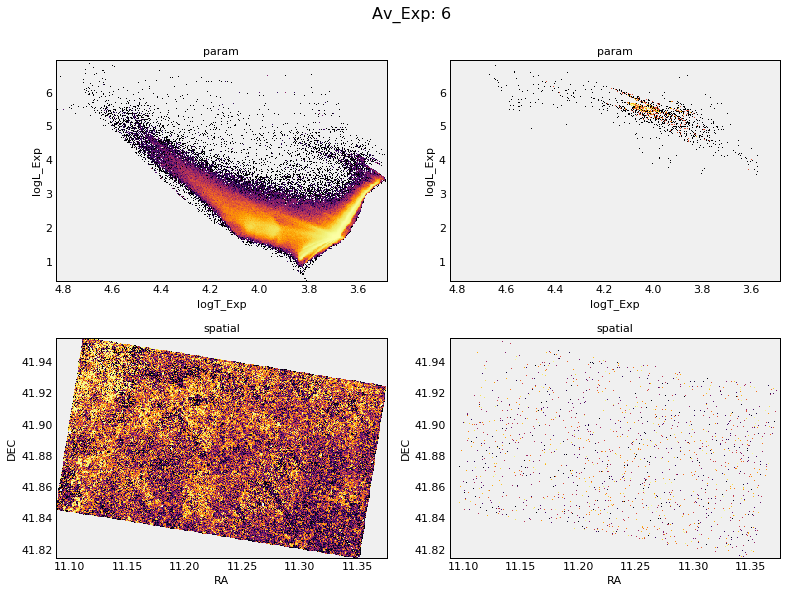

In [10]:
%opts RGB.param [invert_xaxis=True]
hm3.collate().cols(2)